# ACML Homework: Convolutional Autoencoders
by Jonathan Ächtner and Thomas Bahne

# Data preperation and utilities

In [17]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras import layers
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from typing import Tuple

In [18]:
def load_data() -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
  """downloads the cifar10 data set and divides it into a training, validation, and test set

  Returns:
      Tuple[np.ndarray, np.ndarray, np.ndarray]: Train, Validation, Test set
  """ 
  (X_1, y_1), (X_2, y_2) = tf.keras.datasets.cifar10.load_data()
  X = np.vstack((X_1, X_2))
  y = np.vstack((y_1, y_2))
  X_train, X, y_train, y = train_test_split(X, y, train_size=0.8, stratify=y)
  X_test, X_valid, _, _  = train_test_split(X, y, test_size=0.5, stratify=y)
  return X_train, X_valid, X_test

def prepare_images(img: np.ndarray, gray=False) -> np.ndarray:
  """Normalizes and (optinally) grayscales images

  Args:
      img (np.ndarray): Array of images, given in RGB-pixel values
      gray (bool, optional): Set to true will grayscale the images. Defaults to False.

  Returns:
      np.ndarray: Normalized and (optinally) grayscaled array of images
  """  
  img = img/255
  img_s1, img_s2, img_s3, img_s4 = img.shape
  if gray:
    to_grayscale = lambda x: x[:,:,:,0] * 0.299 + x[:,:,:,1] * 0.5870 + x[:,:,:,2] * 0.1140
    img_gray = to_grayscale(img)
    img = img
    return img_gray.reshape((img_s1, img_s2, img_s3, 1))
  else:
    return img.reshape(img.shape)

def load_prepare() -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
  """Downloads the CIFAR10 data set, normalizes and graysclaes the images

  Returns:
      Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]: Normalized Train, Validation and Test sets for color and grayscaled images
  """  
  X_train_new, X_valid_new, X_test_new = load_data()

  X_train = prepare_images(X_train_new)
  X_valid = prepare_images(X_valid_new)
  X_test = prepare_images(X_test_new)

  X_train_bw = prepare_images(X_train_new, True)
  X_test_bw = prepare_images(X_test_new, True)
  X_valid_bw = prepare_images(X_valid_new, True)

  return X_train, X_valid, X_test, X_train_bw, X_valid_bw, X_test_bw

def save_model(model, path = 'models/CAE') -> None:
  model.save(path)

def load_model(path = 'models/CAE') -> None:
    return keras.models.load_model(path)

def img_compare(img_org: np.ndarray, img_pred: np.ndarray, cmap: str='gray') -> None:
  """Plots the original image next to the output of the Autoencoder

  Args:
      img_org (np.ndarray): Original version of the image
      img_pred (np.ndarray): Output of the auto encoder for the image
      cmap (str, optional): [description]. Defaults to 'gray'.
  """  
  plt.subplot(221).imshow(img_org)
  plt.subplot(221).set_title(f'original img: {img_org.shape}')
  if img_pred.shape == (32,32,1):
    img_pred = img_pred.reshape((32,32))
    plt.subplot(222).imshow(img_pred, cmap=cmap)
    plt.subplot(222).set_title(f'predict img: {img_pred.shape}')
  else:
    plt.subplot(222).imshow(img_pred)
    plt.subplot(222).set_title(f'predict img: {img_pred.shape}')
  plt.show()

def model_fit_transform(model, x_train, y_train=None, x_valid=None, y_valid=None, x_test=None, y_test=None, step_size=1e-3, epochs=10):
  model.summary()
  """Fits the model on training data, if available evaluates it on the validation set

  Args:
      model (keras.engine.sequential.Sequential): model to be trained
      x_train (np.ndarray): training inputs
      y_train (np.ndarray): labels of training inputs ()

  Returns:
      Tuple[keras.engine.sequential.Sequential, np.ndarray, np.ndarray, np.ndarray]: fitted model, output of the model for training-, validation-, and test instances, history of training
  """
  if x_valid.any() != None:
    history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=epochs, verbose=1)
  else:
    history = model.fit(x_train, y_train, epochs=epochs, verbose=1)
  if x_valid.any() != None:
    results = model.evaluate(x_valid, y_valid, return_dict = True)
    print('evaluations for validation set')
    for x, y in zip(results.keys(), results.values()):
        print('\t', x, ': ', y)

  predictions_x_train = model.predict(x_train, verbose=1)

  if x_test.any() != None:
    predictions_x_test = model.predict(x_test, verbose=1)
  
  if x_valid.any() != None:
    predictions_x_valid = model.predict(x_valid, verbose=1)
  
  return model, predictions_x_train, predictions_x_valid, predictions_x_test, history

## 1. Divide your dataset into training (80%), validation (10%) and test (10%). Normalize the data.

In [19]:
X_train, X_valid, X_test, X_train_bw, X_valid_bw, X_test_bw = load_prepare()

shape_color_instance = X_train[0].shape
shape_bw_instance = X_train_bw[0].shape

## 2. Implement the autoencoder network specified above. Run the training for at least 10 epochs, and plot the evolution of the error with epochs. Report also the test error.

## model creation

In [25]:
# build the model
def create_model(input_shape):
  model =  Sequential()
  model.add(Input(shape=input_shape))
  model.add(Conv2D(8, kernel_size = (3,3), padding='same',  activation='relu'))
  model.add(MaxPooling2D(pool_size = (2,2), padding='same'))
  model.add(Conv2D(12, kernel_size = (3,3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Conv2D(16, kernel_size = (3,3), padding='same', activation='relu'))
  model.add(UpSampling2D(size=(2,2)))
  model.add(Conv2D(12,kernel_size = (3,3), padding='same', activation='relu'))
  model.add(UpSampling2D())
  model.add(Conv2D(3,(3,3), padding='same', activation='relu'))
  return model

model = create_model(shape_color_instance)

# compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),
              keras.metrics.MeanSquaredError(),
              keras.metrics.CosineSimilarity(),
              keras.metrics.BinaryCrossentropy()])

In [26]:
model, X_train_0, X_valid_0, X_test_0 = model_fit_transform(model, X_train, X_train, X_valid, X_valid, X_test, X_test)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 12)        876       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 12)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 16)          1744      
                                                                 
 up_sampling2d_2 (UpSampling  (None, 16, 16, 16)      

KeyboardInterrupt: 

In [ ]:
# Plot accuracy and report test error
epochs = range(1,11)

plt.figure()
plt.plot(epochs, history.history['loss'], '-', label='Training loss')
plt.plot(epochs, history.history['val_loss'], '--', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# We get a loss of 0 on the test set? Seems to good to be true...
print(f'Test set loss: {model.evaluate(X_test)[0]}')

NameError: name 'history' is not defined

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


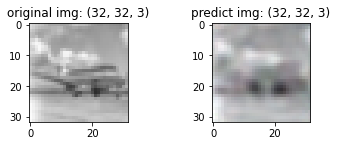

In [10]:
img_compare(X_test[0], X_test_0[0])

## 1. What is the size of the latent space representation of the above network?

These following are the numbers for the variables of the last convultion layer (i.e. the latent space)

Input volume = 8 (8x8)\
Kernel size = 3 (3x3)\
Padding = 1\
Stride = 1\
Channels = 16

Size of latent space = $(\frac{8-3+2\cdot 1}{1}+1)^2\cdot 16$ = 1024

## 2. Try other architectures (e.g. fewer intermediate layers, different number of channels, filter sizes or stride and padding configurations) to answer questions such as: What is the impact of those in the reconstruction error after training? Is there an obvious correlation between the size of the latent space representation and the error?

### drastically improving Filter size 

In [8]:
model_layout01 = Sequential()
model_layout01.add(Input(shape=sample_shape))
model_layout01.add(Conv2D(128, kernel_size = (3,3), padding='same',  activation='relu'))
model_layout01.add(Conv2D(92, kernel_size = (3,3), padding='same',  activation='relu'))
model_layout01.add(MaxPooling2D(pool_size = (2,2)))
model_layout01.add(Conv2D(78, kernel_size = (3,3), padding='same', activation='relu'))
model_layout01.add(MaxPooling2D(pool_size = (2,2)))
model_layout01.add(Conv2D(64, kernel_size = (3,3), padding='same', activation='relu'))

model_layout01.add(UpSampling2D(size=(2,2)))
model_layout01.add(Conv2D(32,kernel_size = (3,3), padding='same', activation='relu'))
model_layout01.add(Conv2D(24,kernel_size = (3,3), padding='same', activation='relu'))
model_layout01.add(Conv2D(16,kernel_size = (3,3), padding='same', activation='relu'))

model_layout01.add(UpSampling2D())
model_layout01.add(Conv2D(8,kernel_size = (3,3), padding='same', activation='relu'))
model_layout01.add(Conv2D(3,(3,3), padding='same', activation='relu'))

model_layout01.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),
            keras.metrics.CosineSimilarity()])


In [14]:
model_layout01, X_train_1, X_valid_1, X_test_1 = model_fit_transform(model_layout01, X_train, X_valid, X_test, epochs=20)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 92)        106076    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 92)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 78)        64662     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 78)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          44992     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 64)       

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


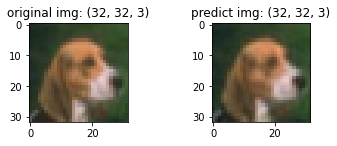

In [18]:
img_compare(X_test[1], X_test_1[1])

### using more max_pool to shrink the model further

In [20]:
model_layout02 = Sequential()
model_layout02.add(Input(shape=sample_shape))
model_layout02.add(Conv2D(8, kernel_size = (3,3), padding='same',  activation='relu'))
model_layout02.add(MaxPooling2D(pool_size = (2,2), padding='same'))
model_layout02.add(Conv2D(12, kernel_size = (3,3), padding='same', activation='relu'))
model_layout02.add(MaxPooling2D(pool_size = (2,2)))
model_layout02.add(Conv2D(16, kernel_size = (3,3), padding='same', activation='relu'))
model_layout02.add(MaxPooling2D(pool_size = (2,2)))
model_layout02.add(Conv2D(32, kernel_size = (3,3), padding='same', activation='relu'))
model_layout02.add(UpSampling2D(size=(2,2)))
model_layout02.add(Conv2D(16,kernel_size = (3,3), padding='same', activation='relu'))
model_layout02.add(UpSampling2D())
model_layout02.add(Conv2D(8,kernel_size = (3,3), padding='same', activation='relu'))
model_layout02.add(UpSampling2D())
model_layout02.add(Conv2D(3,(3,3), padding='same', activation='relu'))


# compile the model_layout02
model_layout02.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),
            keras.metrics.CosineSimilarity()])

model_layout02.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 12)        876       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 12)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 16)          1744      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 4, 32)         

In [ ]:
model_layout02, X_train_2, X_valid_2, X_test_2 = model_fit_transform(model_layout02, X_train, X_valid, X_test)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 12)        876       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 12)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 16)          1744      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 4, 32)         

In [ ]:
img_compare(X_test[1], X_test_2[1])

### trying setup to improve sharpness of the model

In [13]:
model_layout03 = Sequential()
model_layout03.add(Input(shape=sample_shape))
model_layout03.add(Conv2D(32, kernel_size = (3,3), padding='same',  activation='relu'))
model_layout03.add(MaxPooling2D(pool_size = (2,2), padding='same'))
model_layout03.add(Conv2D(64, kernel_size = (3,3), padding='same', activation='relu'))
model_layout03.add(MaxPooling2D(pool_size = (2,2)))
model_layout03.add(Conv2D(128, kernel_size = (3,3), padding='same', activation='relu'))
model_layout03.add(UpSampling2D(size=(2,2)))
model_layout03.add(Conv2D(64,kernel_size = (3,3), padding='same', activation='relu'))
model_layout03.add(UpSampling2D())
model_layout03.add(Conv2D(32, kernel_size = (3,3), padding='same',  activation='relu'))
model_layout03.add(Conv2D(16, kernel_size = (3,3), padding='same',  activation='relu'))
model_layout03.add(Conv2D(3,(3,3), padding='same', activation='sigmoid'))


# compile the model_layout03
model_layout03.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),
            keras.metrics.CosineSimilarity()])


"\nfor layer in model_layout03.layers:\n  # ensure stride = 1 in all layers having stride attribute.\n  if hasattr(layer, 'strides'):\n    setattr(layer, 'strides', 1)\n  if hasattr(layer, 'padding'):\n    setattr(layer, 'padding', 'same')\n\n"

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 64)        9280      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)       

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


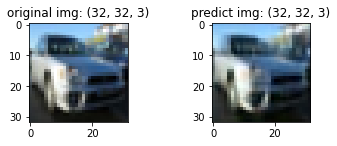

In [15]:
model_layout03, X_train_3, X_valid_3, X_test_3 = model_fit_transform(model_layout03, X_train, X_valid, X_test)
img_compare(X_test[0], X_test_3[0])

### model with only 1 conv. filters

In [9]:
model_layout04 = Sequential()
model_layout04.add(Input(shape=sample_shape))
model_layout04.add(Conv2D(3, kernel_size = (3,3), padding='same',  activation='relu'))


model_layout04.compile(
  optimizer=keras.optimizers.Adam(learning_rate=1e-3),
  loss=keras.losses.MeanSquaredError(),
  metrics=[keras.metrics.MeanAbsoluteError(),
          keras.metrics.CosineSimilarity()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 3)         84        
Total params: 84
Trainable params: 84
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0086 - mean_absolute_error: 0.0472 - cosine_similarity: 0.9817 - val_loss: 7.5289e-04 - val_mean_absolute_error: 0.0176 - val_cosine_similarity: 0.9949
Epoch 2/10
1500/1500 [==============================] - 6s 4ms/step - loss: 4.3399e-04 - mean_absolute_error: 0.0129 - cosine_similarity: 0.9965 - val_loss: 2.2831e-04 - val_mean_absolute_error: 0.0093 - val_cosine_similarity: 0.9972
Epoch 3/10
1500/1500 [==============================] - 6s 4ms/step - loss: 1.3080e-04 - mean_absolute_error: 0.0068 - cosine_similarity: 0.9979 - val_loss: 6.8044e-05 - val_mean_absolute_er

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


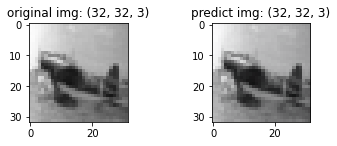

In [11]:
model_layout04, X_train_4, X_valid_4, X_test_4 = model_fit_transform(model_layout04, X_train, X_valid, X_test)
img_compare(X_test[1], X_test_4[1])

## stuff

### learn seperate model for greyscale and model for combination of color and grayscale

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


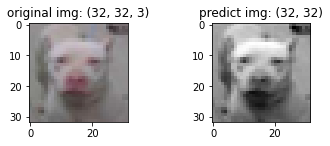

In [8]:
img_compare(X_train[0], X_train_bw[0])

In [9]:
# build the model_bw

model_bw = Sequential()
model_bw.add(Input(shape=X_train_bw[0].shape))
model_bw.add(Conv2D(8, kernel_size = (3,3), padding='same',  activation='relu'))
model_bw.add(Conv2D(12, kernel_size = (3,3), padding='same',  activation='relu'))
model_bw.add(MaxPooling2D(pool_size = (2,2)))
model_bw.add(Conv2D(16, kernel_size = (3,3), padding='same', activation='relu'))
model_bw.add(MaxPooling2D(pool_size = (2,2)))
model_bw.add(Conv2D(32, kernel_size = (3,3), padding='same', activation='relu'))
model_bw.add(Conv2D(32, kernel_size = (3,3), padding='same', activation='relu'))
model_bw.add(UpSampling2D(size=(2,2)))
model_bw.add(Conv2D(16,kernel_size = (3,3), padding='same', activation='relu'))
model_bw.add(UpSampling2D())
model_bw.add(Conv2D(12,kernel_size = (3,3), padding='same', activation='relu'))
model_bw.add(UpSampling2D())
model_bw.add(Conv2D(6,kernel_size = (3,3), padding='same', activation='relu'))
model_bw.add(MaxPooling2D(pool_size = (2,2)))
model_bw.add(Conv2D(1,(3,3), padding='same', activation='relu'))


# compile the model_bw
model_bw.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),
            keras.metrics.CosineSimilarity()])

model_bw.summary()

KeyboardInterrupt: ignored

In [ ]:
# learn model for bw representation

history_bw = model_bw.fit(X_train_bw, X_train_bw, epochs=10, validation_data=(X_valid_bw, X_valid_bw), verbose=1, use_multiprocessing=True)

In [ ]:
# evaluate bw model
model_bw.evaluate(X_test_bw, X_test_bw)

In [ ]:
predictions_bw = model_bw.predict(X_train_bw, verbose=1)

In [ ]:
predictions_bw.shape
X_train_comb = np.concatenate((predictions, predictions_bw),3)

In [ ]:
# build model_comb for combination of prediction model_comb

model_comb = Sequential()
model_comb.add(Input(shape=X_train_comb[0].shape))
model_comb.add(Conv2D(8, kernel_size = (3,3), padding='same',  activation='relu'))
model_comb.add(MaxPooling2D(pool_size = (2,2)))
model_comb.add(Conv2D(12, kernel_size = (3,3), padding='same', activation='relu'))
model_comb.add(MaxPooling2D(pool_size = (2,2)))
model_comb.add(Conv2D(16, kernel_size = (3,3), padding='same', activation='relu'))
model_comb.add(UpSampling2D(size=(2,2)))
model_comb.add(Conv2D(12,kernel_size = (3,3), padding='same', activation='relu'))
model_comb.add(UpSampling2D())
model_comb.add(Conv2D(3,(3,3), padding='same', activation='relu'))


# compile the model_comb
model_comb.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),
            keras.metrics.CosineSimilarity()])

model_comb.summary()

In [ ]:
history_comb = model_comb.fit(X_train_comb, X_train, epochs=7, verbose=1, use_multiprocessing=True)

In [ ]:
predict_comb = model_comb.predict()

def comp_comb_org(comb_img, org_img):
    plt.subplot(221).imshow(org_img)
    plt.subplot(221).set_title(f'original img: {org_img.shape}')
    plt.subplot(222).imshow(comb_img)
    plt.subplot(222).set_title(f'predict img: {comb_img.shape}')
    plt.show()


In [ ]:
img_compare(X_train[0], predict_comb[0])

In [ ]:
save_model(model_comb, 'models/model_pipe_comb')
save_model(model_bw, 'models/model_pipe_bw')

### try model_test for recolorization

In [ ]:
model_test = Sequential()
# model_test.add(Input(shape=X_train_bw.shape))
model_test.add(Conv2D(16, kernel_size = (3,3), padding='same',  activation='relu', input_shape=(32,32,1)))
# model_test.add(Conv2D(8, kernel_size = (3,3), padding='same',  activation='relu'))
# model_test.add(Conv2D(32, kernel_size = (3,3), padding='same', activation='relu'))
model_test.add(MaxPooling2D(pool_size = (2,2)))
# model_test.add(Conv2D(64, kernel_size = (3,3), padding='same', activation='relu'))
model_test.add(Conv2D(32,kernel_size = (3,3), padding='same', activation='relu'))
model_test.add(MaxPooling2D(pool_size = (2,2)))
model_test.add(Conv2D(64,kernel_size = (3,3), padding='same', activation='relu'))
# model_test.add(Conv2D(32,kernel_size = (3,3), padding='same', activation='relu'))

model_test.add(UpSampling2D())
model_test.add(Conv2D(24,kernel_size = (3,3), padding='same', activation='relu'))
model_test.add(Conv2D(16,kernel_size = (3,3), padding='same', activation='relu'))
model_test.add(UpSampling2D())

model_test.add(Conv2D(12,kernel_size = (3,3), padding='same', activation='relu'))
model_test.add(Conv2D(3,(3,3), padding='same', activation='sigmoid'))


model_test.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),
            keras.metrics.CosineSimilarity(),
             keras.metrics.Accuracy()])
model_test.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 24)       

In [ ]:
print(X_train_bw.shape, X_train.shape)

model_test.fit(X_train_bw, X_train, validation_data=(X_valid_bw, X_valid), epochs=10, verbose=1)
predictions_test_recol = model_test.predict(X_test_bw, verbose=1)

(48000, 32, 32, 1) (48000, 32, 32, 3)
Epoch 1/10
1500/1500 [==============================] - 46s 11ms/step - loss: 0.0113 - mean_absolute_error: 0.0778 - cosine_similarity: 0.9796 - accuracy: 2.2380e-07 - val_loss: 0.0087 - val_mean_absolute_error: 0.0687 - val_cosine_similarity: 0.9801 - val_accuracy: 2.1701e-07
Epoch 2/10
1500/1500 [==============================] - 16s 10ms/step - loss: 0.0087 - mean_absolute_error: 0.0684 - cosine_similarity: 0.9801 - accuracy: 2.5770e-07 - val_loss: 0.0084 - val_mean_absolute_error: 0.0673 - val_cosine_similarity: 0.9805 - val_accuracy: 2.1701e-07
Epoch 3/10
1500/1500 [==============================] - 16s 10ms/step - loss: 0.0084 - mean_absolute_error: 0.0668 - cosine_similarity: 0.9800 - accuracy: 1.7632e-07 - val_loss: 0.0079 - val_mean_absolute_error: 0.0648 - val_cosine_similarity: 0.9801 - val_accuracy: 3.7977e-07
Epoch 4/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0082 - mean_absolute_error: 0.0661 - cosine_simi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


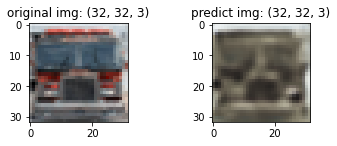

In [ ]:
img_compare(X_test[1], predictions_test_recol[1])

### try 4 models for color channels/grayscales dimensions and one for combination.

In [9]:
small_model_color = Sequential()
small_model_color.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
small_model_color.add(MaxPooling2D())
small_model_color.add(Conv2D(32, kernel_size = (3,3), padding='same',  activation='relu'))
small_model_color.add(MaxPooling2D())
small_model_color.add(Conv2D(64, kernel_size = (3,3), padding='same',  activation='relu'))
small_model_color.add(UpSampling2D())
small_model_color.add(Conv2D(32, kernel_size = (3,3), padding='same',  activation='relu'))
small_model_color.add(UpSampling2D())
small_model_color.add(Conv2D(16, (3,3), padding='same', activation='relu'))
small_model_color.add(Conv2D(1, (3,3), padding='same', activation='sigmoid'))


small_model_color.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),
            keras.metrics.CosineSimilarity(),
             keras.metrics.Accuracy()])

In [10]:
small_model_r, X_train_r, X_valid_r, X_test_r = model_fit_transform(small_model_color, X_train_bw, X_train[:,:,:,0], X_valid_bw, X_valid[:,:,:,0], X_test_bw, X_test[:,:,:,0])
small_model_g, X_train_g, X_valid_g, X_test_g = model_fit_transform(small_model_color, X_train_bw, X_train[:,:,:,1], X_valid_bw, X_valid[:,:,:,1], X_test_bw, X_test[:,:,:,1])
small_model_b, X_train_b, X_valid_b, X_test_b = model_fit_transform(small_model_color, X_train_bw, X_train[:,:,:,2], X_valid_bw, X_valid[:,:,:,2], X_test_bw, X_test[:,:,:,2])
small_model_gray, X_train_gray, X_valid_gray, X_test_gray = model_fit_transform(small_model_color, X_train_bw, X_train_bw, X_valid_bw, X_valid_bw, X_test_bw, X_test_bw)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 32)       

In [12]:
X_train_colstack = np.stack((X_train_r, X_train_g, X_train_b, X_train_gray), 3).reshape((48000,32,32,4))
X_valid_colstack = np.stack((X_valid_r, X_valid_g, X_valid_b, X_valid_gray), 3).reshape((6000,32,32,4))
X_test_colstack = np.stack((X_test_r, X_test_g, X_valid_b, X_valid_gray), 3).reshape((6000,32,32,4))


In [ ]:
model_comb_recol = Sequential()
model_comb_recol.add(Input(shape=X_train_colstack[0].shape))
model_comb_recol.add(Conv2D(128, kernel_size = (3,3), padding='same',  activation='relu'))
model_comb_recol.add(Conv2D(92, kernel_size = (3,3), padding='same',  activation='relu'))
model_comb_recol.add(MaxPooling2D(pool_size = (2,2)))
model_comb_recol.add(Conv2D(78, kernel_size = (3,3), padding='same', activation='relu'))
model_comb_recol.add(MaxPooling2D(pool_size = (2,2)))
model_comb_recol.add(Conv2D(64, kernel_size = (3,3), padding='same', activation='relu'))

model_comb_recol.add(UpSampling2D(size=(2,2)))
model_comb_recol.add(Conv2D(32,kernel_size = (3,3), padding='same', activation='relu'))
model_comb_recol.add(Conv2D(24,kernel_size = (3,3), padding='same', activation='relu'))
model_comb_recol.add(Conv2D(16,kernel_size = (3,3), padding='same', activation='relu'))

model_comb_recol.add(UpSampling2D())
model_comb_recol.add(Conv2D(8,kernel_size = (3,3), padding='same', activation='relu'))
model_comb_recol.add(Conv2D(3,(3,3), padding='same', activation='relu'))

model_comb_recol.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),
            keras.metrics.CosineSimilarity()])

model_col_comb, X_train_col_comb, X_valid_col_comb, X_test_col_comb = model_fit_transform(model_comb_recol, X_train_colstack, X_train, X_valid_colstack, X_valid, X_test_colstack, X_test)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 128)       4736      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 92)        106076    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 92)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 78)        64662     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 78)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 64)          44992     
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 16, 16, 64)       

In [ ]:
img_compare(X_test[0], X_test_col_comb[0])